In [131]:
import pandas_datareader.data as web    # pandas 0.19.x and later
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import datetime
import plotly.io as pio
pio.renderers.default = 'svg'
import plotly.express as px

In [132]:
start = datetime.datetime(1960, 1, 1)
end = datetime.datetime(2023, 1, 27)
df = pd.DataFrame([])
df['y'] = web.DataReader("A191RO1Q156NBEA", "fred", start, end)
df['p'] = web.DataReader("BPCCRO1Q156NBEA", "fred", start, end)
df['i'] = web.DataReader("FEDFUNDS", "fred", start, end).resample('QS').mean()
df['t'] = np.array(range(df.shape[0]))
df.head()

,y,p,i,t
DATE,,,,
1960-01-01,4.9,2.1,3.933333,0
1960-04-01,2.1,2.0,3.696667,1
1960-07-01,2.5,1.7,2.936667,2
1960-10-01,0.9,1.4,2.296667,3
1961-01-01,-0.7,1.3,2.003333,4


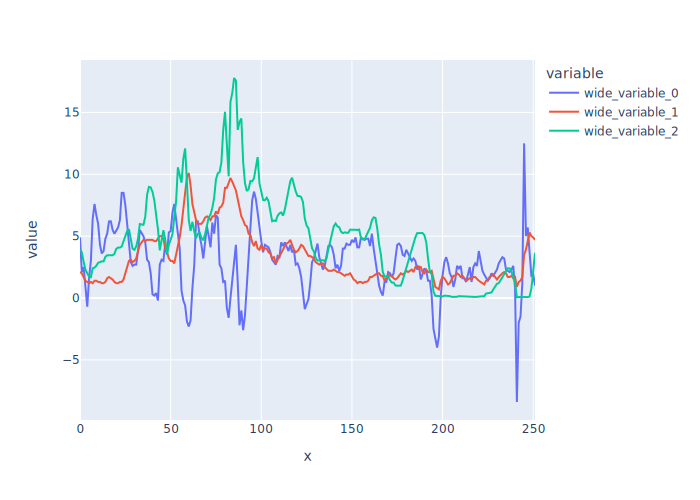

In [133]:
px.line(y=[df.y,df.p,df.i],x=df.t)

In [134]:
lags = 4
for i in range(1,lags):
    name = 'y.'+str(i)
    df[name] = df.y.shift(i)
    name = 'p.'+str(i)
    df[name] = df.p.shift(i)
    name = 'i.'+str(i)
    df[name] = df.i.shift(i)
df = df.iloc[i:]

### System OLS

In [135]:
Y = df[['y','p','i']].to_numpy()
X1 = df.filter(regex=("y.*"))
X2 = df.filter(regex=("p.*"))
X3 = df.filter(regex=("i.*"))
X = np.c_[np.ones(X1.shape[0]),X1.iloc[:,1:],X2.iloc[:,1:],X3.iloc[:,1:]]
θ_hat = np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))
θ_hat

array([[ 1.0067702 ,  0.10583668, -0.31643254],
       [ 0.84803824, -0.02298924,  0.01109639],
       [ 0.08235247,  0.00925516,  0.07819583],
       [-0.21149859,  0.00825242,  0.02449901],
       [-0.82351805,  1.38959996,  0.29177324],
       [ 0.76947779, -0.30261855, -0.46445895],
       [ 0.02758298, -0.12589682,  0.30769918],
       [ 0.26518902,  0.04582209,  1.17439349],
       [-0.41508089,  0.0133446 , -0.46123813],
       [ 0.13482773, -0.05025137,  0.1914963 ]])

### Equation by Equation

In [136]:
ys = ['y','p','i']
θs = []
for i in ys:
    y = df[i].to_numpy()
    x = X 
    θ = np.dot(np.linalg.inv(np.dot(x.T,x)),np.dot(x.T,y))
    θs.append(np.round(θ,1))
θs  

[array([ 1. ,  0.8,  0.1, -0.2, -0.8,  0.8,  0. ,  0.3, -0.4,  0.1]),
 array([ 0.1, -0. ,  0. ,  0. ,  1.4, -0.3, -0.1,  0. ,  0. , -0.1]),
 array([-0.3,  0. ,  0.1,  0. ,  0.3, -0.5,  0.3,  1.2, -0.5,  0.2])]

In [137]:
e = Y- np.dot(X, θ_hat)
print('Correlation of residuals')
np.corrcoef([e[:,0],e[:,1],e[:,2]])

Correlation of residuals


array([[1.        , 0.33550329, 0.24988117],
       [0.33550329, 1.        , 0.2408855 ],
       [0.24988117, 0.2408855 , 1.        ]])

In [129]:
e = Y- np.dot(X, θ_hat)
Σ_hat = (1/X.shape[0])*np.dot(e.T,e)
#θ_Var = np.dot(Σ_hat,np.linalg.inv(np.dot(X.T, X)))

### Canned Solution

In [130]:
from statsmodels.tsa.api import VAR
model = VAR(df[['y','p','i']])
results = model.fit(4)
results.summary()

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 18, Feb, 2023
Time:                     02:12:24
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.66299
Nobs:                     245.000    HQIC:                  -1.99589
Log likelihood:          -731.929    FPE:                   0.108605
AIC:                     -2.22034    Det(Omega_mle):       0.0930015
--------------------------------------------------------------------
Results for equation y
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         1.221343         0.239739            5.094           0.000
L1.y          0.786717         0.069165           11.374           0.000
L1.p         -0.738560         0.318418           -2.319           0.020
L1.i          0.294774 